In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from img_utils import *
path = "../nybolig-scrape/output_raw"
from img_utils import data_to_df
#try reloading the module
IMAGE_WIDTH: int = 224
IMAGE_HEIGHT: int = 224


# Load Data
train_1_path: str = "output/train/train_1"
train_2_path: str = "output/train/train_2"
valid_path: str = "output/valid"
test_path: str = "output/test"


# train_1_path: str = "output/train/train_1"
# train_2_path: str = "output/train/train_2"
# valid_path: str = "output/valid"
# test_path: str = "output/test"

train1_df, train2_df, valid_df, test_df = data_to_df(
    [train_1_path, train_2_path, valid_path, test_path], preprocess=False
)

houses_df = pd.concat([train1_df, train2_df, valid_df, test_df], ignore_index=True)

Processing output/test: 100%|██████████| 178/178 [00:00<00:00, 626330.63it/s]


In [4]:
print(len(houses_df))

890


# 1. Data Exploration

In [5]:
from utils import prepare_features
display(houses_df.head(1))
#Remove url 
houses_df = houses_df.drop(columns=["url"])
#houses_df_ = prepare_features(houses_df)
#display(houses_df_.head(1))

,url,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,postal_avg_sqm_price,lat,lng,image_floorplan
0,https://danbolig.dk/bolig/gladsaxe/2860/lejlig...,Niels Finsens Alle 90 st.. tv. 2860 Søborg,2860,ejerlejlighed,1750000,40,None,2.0,1944.0,NaN,C,32687.5,55.7369662412981,12.5131171327647,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


,postal_code,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,postal_avg_sqm_price,lat,lng,image_floorplan
0,1.271036,1750000,-1.278642,0.0,-0.820002,-0.175611,-0.287371,-0.15122,32687.5,55.7369662412981,12.5131171327647,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


Data description:


,postal_code,price,size,rooms,year_built,year_rebuilt,postal_avg_sqm_price
count,890.000000,8.900000e+02,890.000000,886.000000,885.000000,69.000000,890.000000
mean,2337.933708,4.156278e+06,83.103371,2.860045,1952.345763,1991.869565,41383.279213
std,429.623105,2.706691e+06,33.729228,1.049426,47.551118,23.500884,15214.893950
min,1051.000000,2.750000e+05,15.000000,0.000000,1623.000000,1933.000000,0.000000
25%,2100.000000,2.445000e+06,60.000000,2.000000,1932.000000,1978.000000,33507.500000
50%,2300.000000,3.347500e+06,76.000000,3.000000,1954.000000,1996.000000,44946.750000
75%,2680.000000,4.995000e+06,99.000000,4.000000,1981.000000,2009.000000,51502.500000
max,2900.000000,2.700000e+07,324.000000,8.000000,2023.000000,2022.000000,65007.000000


\begin{tabular}{lrrrrrrr}
\toprule
{} &  postal\_code &     price &  size &  rooms &  year\_built &  year\_rebuilt &  postal\_avg\_sqm\_price \\
\midrule
count &          890 &       890 &   890 &    886 &         885 &            69 &                   890 \\
mean  &         2337 &   4156277 &    83 &      2 &        1952 &          1991 &                 41383 \\
std   &          429 &   2706690 &    33 &      1 &          47 &            23 &                 15214 \\
min   &         1051 &    275000 &    15 &      0 &        1623 &          1933 &                     0 \\
25\%   &         2100 &   2445000 &    60 &      2 &        1932 &          1978 &                 33507 \\
50\%   &         2300 &   3347500 &    76 &      3 &        1954 &          1996 &                 44946 \\
75\%   &         2680 &   4995000 &    99 &      4 &        1981 &          2009 &                 51502 \\
max   &         2900 &  27000000 &   324 &      8 &        2023 &          2022 &             

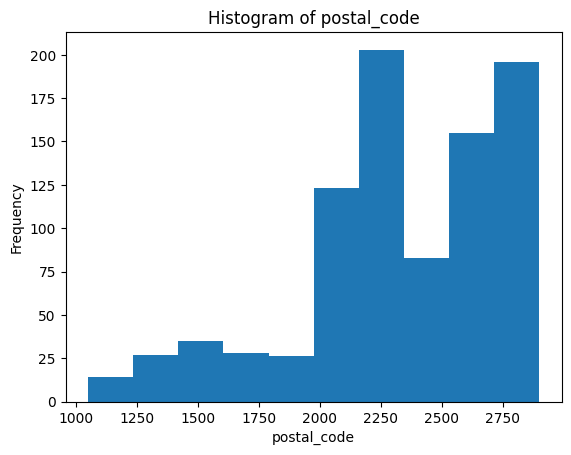

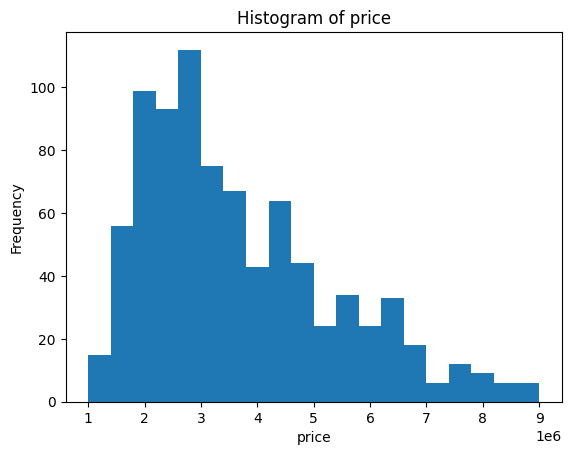

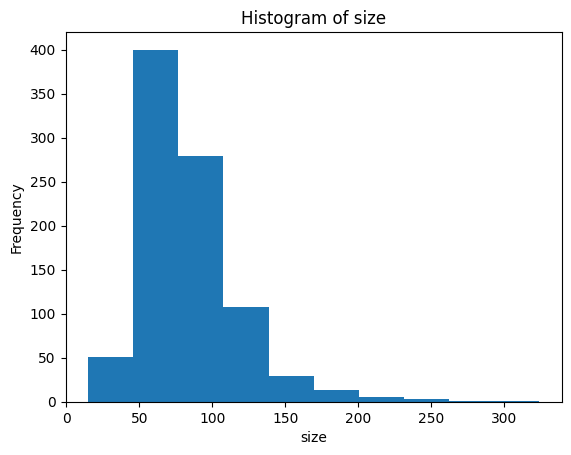

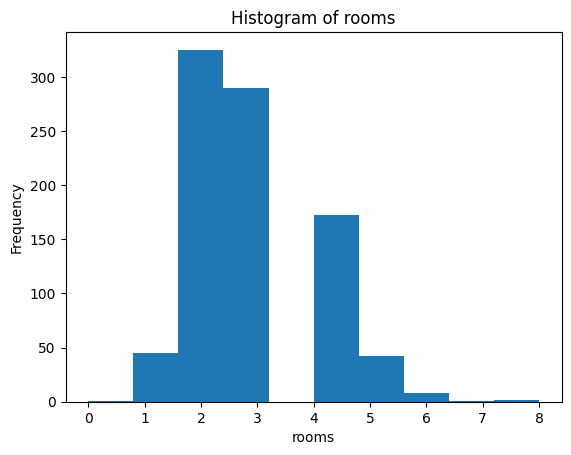

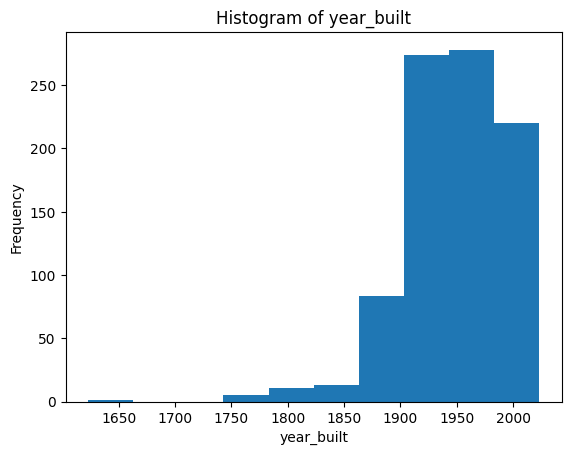

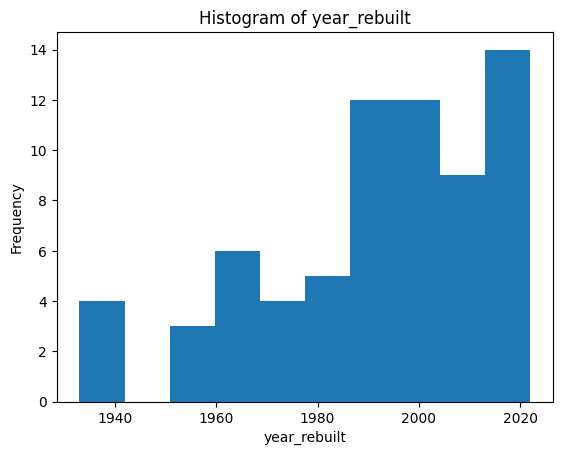

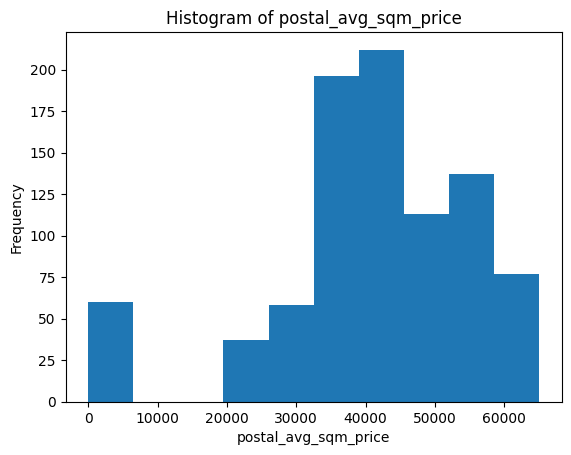

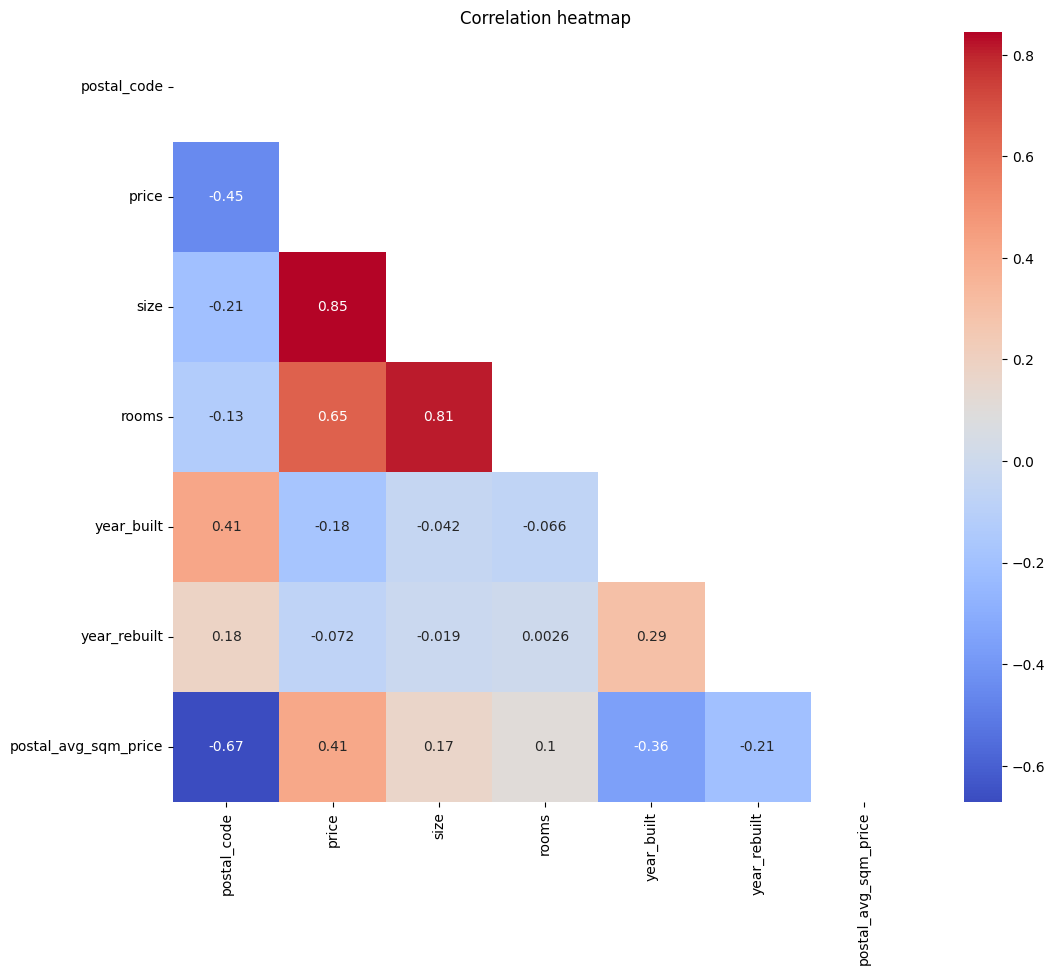

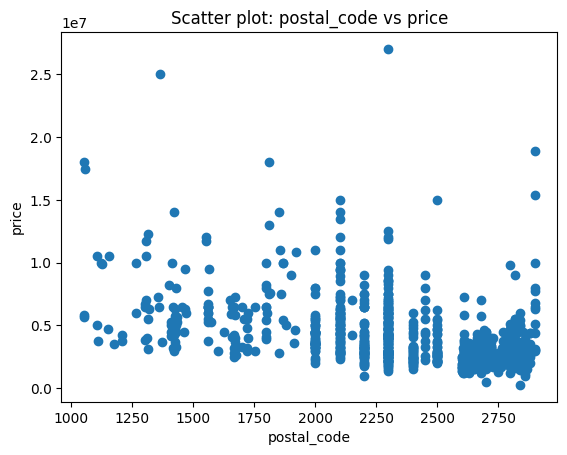

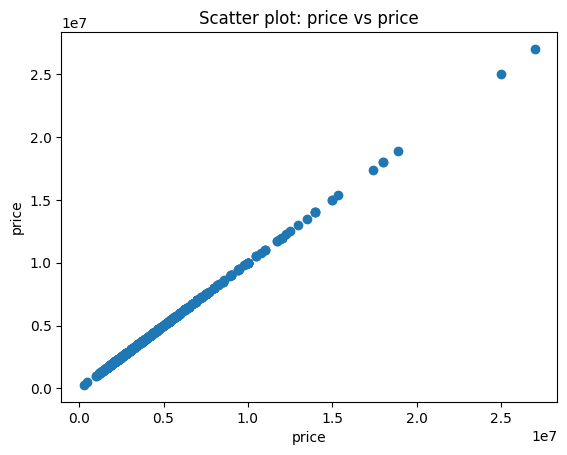

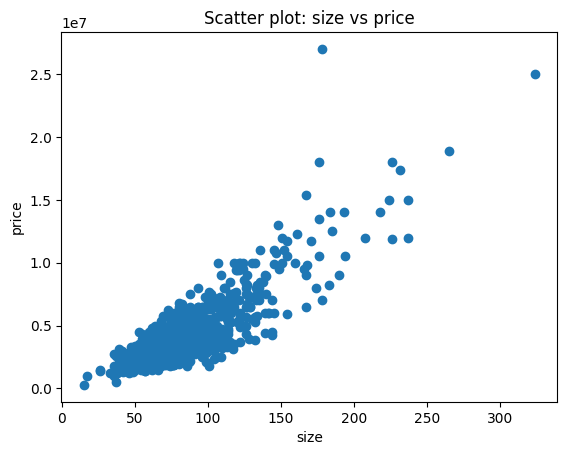

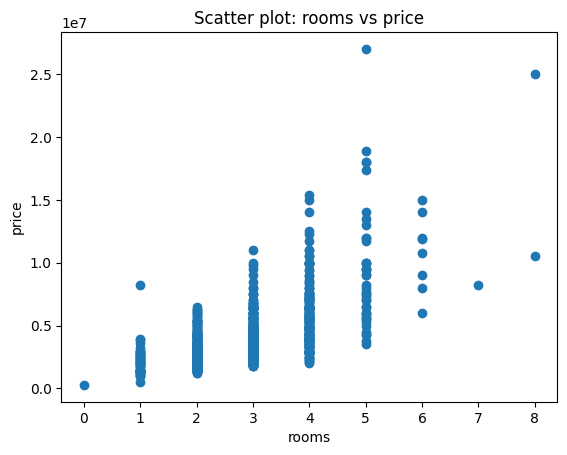

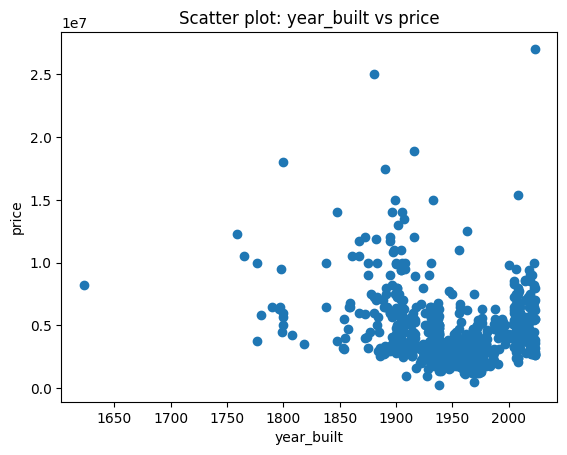

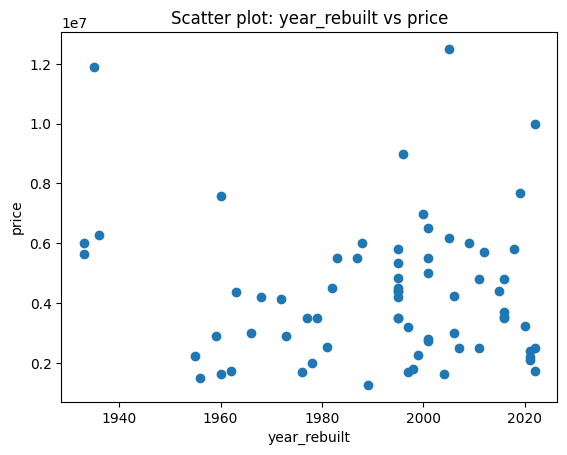

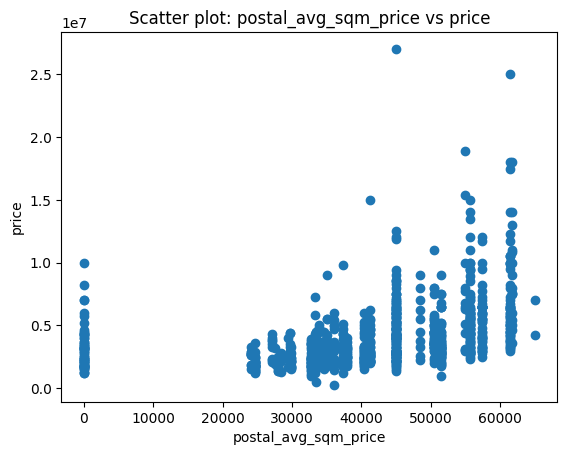

In [8]:
from DataExploration import full_summary
full_summary(houses_df)

In [12]:
# from img_utils import preprocess_images
# train_images_448 = preprocess_images(
#     houses_df_, "image_floorplan", 448, 448, True, False, False)

In [26]:
# import numpy as np
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Flatten, Dense, Dropout
# from tensorflow.keras import regularizers
# from tensorflow.keras.utils import plot_model
# pretrained_model = VGG16
# images = train_images_448

# def CNN_model(
#     # pretrained_model, custom_layers, train_images, y_train, validation_images, y_valid
#     pretrained_model: object,
#     custom_layers: bool,
#     train_images: np.array,
#     y_train: np.array,
#     validation_images: np.array,
#     y_valid: np.array,
# ):
#     # Load the Pretrained Model
#     target_width = train_images[0].shape[0]
#     target_height = train_images[0].shape[1]
#     input_shape = (target_width, target_height, 3)
#     base_model = pretrained_model(
#         weights="imagenet", include_top=False, input_shape=input_shape
#     )

#     # Freeze the pretrained weights
#     for layer in base_model.layers:
#         layer.trainable = False

#     # Create the model with the pretrained model and a new classification layer
#     if custom_layers:
#         model = Sequential(
#             [
#                 base_model,
#                 Flatten(),
#                 Dense(512, activation="relu", kernel_regularizer=regularizers.l1(0.01)),
#                 # BatchNormalization(),
#                 Dropout(0.1),
#                 Dense(256, activation="relu", kernel_regularizer=regularizers.l1(0.01)),
#                 Dropout(0.1),
#                 Dense(128, activation="relu"),
#                 Dense(64, activation="relu"),
#                 Dense(1, activation="linear"),
#             ]
#         )
#     else:
#         model = Sequential([base_model, Flatten(), Dense(1, activation="linear")])

#     # Check which type of model we are building
#     model.compile(
#         optimizer="Adam", loss="mean_absolute_error", metrics=["mean_absolute_error"]
#     )
#     return model

# model = CNN_model(pretrained_model, custom_layers=True, train_images=images, y_train=houses_df_["price"], validation_images=images, y_valid=houses_df_["price"])


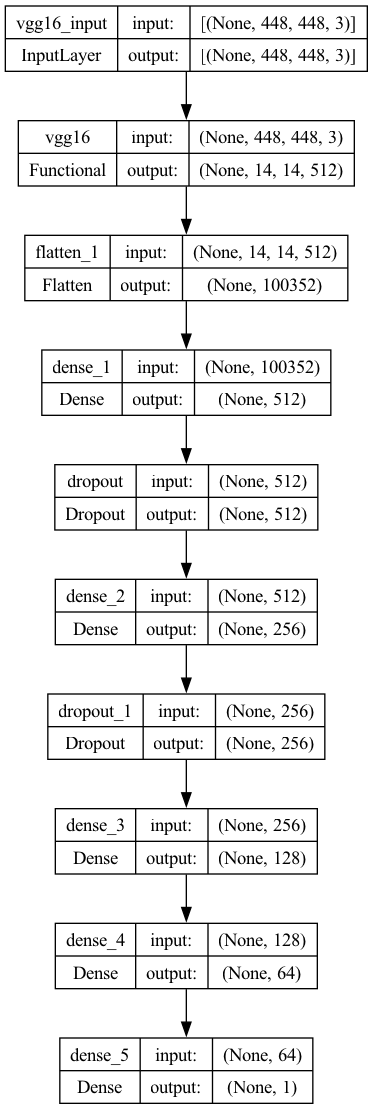

In [29]:
#plot the model archetecture 
img = plot_model(model, to_file="VGG16_Architecture.png",
                 show_shapes=True, show_layer_names=True, show_trainable=False,
                 rankdir="TB", expand_nested=False, dpi=96)
#€plot the image
from IPython.display import Image
Image(filename="VGG16_Architecture.png")

